# **Start the Project**

In [4]:
import pandas as pd
import numpy as np
import joblib
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# **Data Loading**

In [5]:
# Load dataset
df = pd.read_csv("data.csv", encoding="latin1")

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# **Data Cleaning**

In [8]:
# Cek jumlah duplikasi berdasarkan kolom 'Description'
duplicate_counts = df['Description'].value_counts()
duplicates = duplicate_counts[duplicate_counts > 1]

print(f"Jumlah deskripsi yang terduplikasi: {len(duplicates)}")
print("Deskripsi yang terduplikasi:")
print(duplicates.head(10))  # Tampilkan 10 deskripsi teratas yang memiliki duplikasi

Jumlah deskripsi yang terduplikasi: 3915
Deskripsi yang terduplikasi:
Description
WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
ASSORTED COLOUR BIRD ORNAMENT         1501
SET OF 3 CAKE TINS PANTRY DESIGN      1473
PACK OF 72 RETROSPOT CAKE CASES       1385
LUNCH BAG  BLACK SKULL.               1350
NATURAL SLATE HEART CHALKBOARD        1280
Name: count, dtype: int64


In [9]:
df = df.dropna(subset=['Description'])  # Hapus nilai kosong

In [10]:
df = df.drop_duplicates()  # Hapus duplikasi

In [11]:
df['Description'] = df['Description'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))  # Hapus karakter non-alfabet

In [12]:
df['Description'] = df['Description'].str.lower()  # Konversi ke huruf kecil

In [13]:
df = df[df['Description'].str.len() > 2]  # Hapus deskripsi terlalu pendek

In [14]:
# Hapus duplikasi berdasarkan StockCode, hanya simpan satu entri unik per StockCode
df = df.drop_duplicates(subset=['StockCode'])

In [15]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart tlight holder,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# **Exploratory Data Analysis**

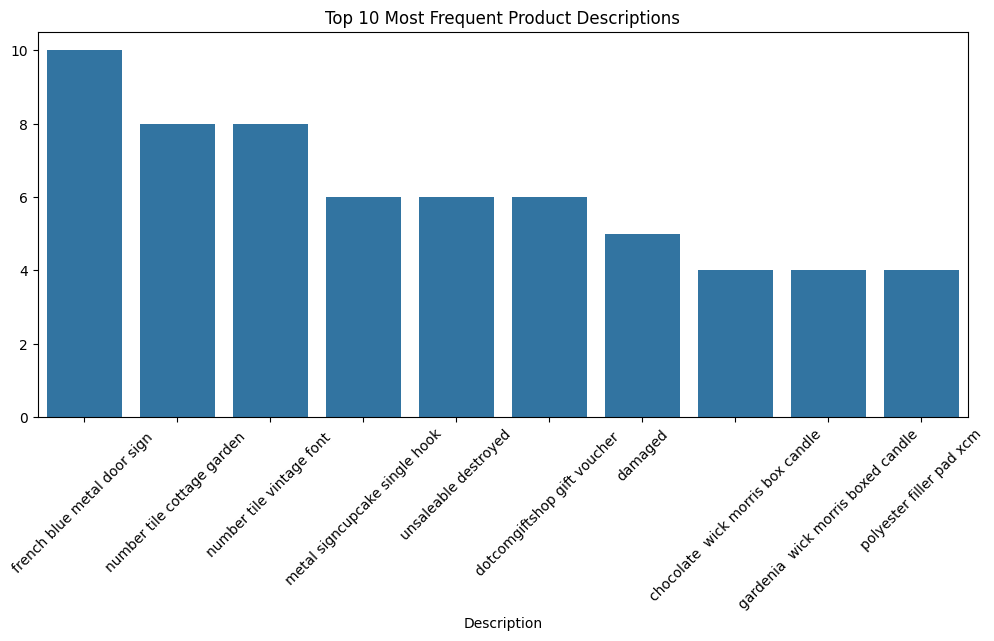

In [16]:
plt.figure(figsize=(12, 5))
sns.barplot(x=df['Description'].value_counts().head(10).index, y=df['Description'].value_counts().head(10).values)
plt.xticks(rotation=45)
plt.title("Top 10 Most Frequent Product Descriptions")
plt.show()

In [17]:
# Fungsi pencarian berdasarkan keyword
def search_by_keyword(df, keyword):
    keyword = keyword.lower()
    return df[df['Description'].str.contains(keyword, regex=False)]

In [18]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(df['Description'])

In [19]:
# Model Nearest Neighbors
model = NearestNeighbors(n_neighbors=5, metric='cosine')
model.fit(X_tfidf)

NearestNeighbors(metric='cosine')

In [20]:
# Simpan model untuk digunakan di Streamlit
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(model, 'nearest_neighbors.pkl')

['nearest_neighbors.pkl']

In [21]:
# Fungsi rekomendasi dengan filter keyword
def recommend_products(keyword, num_recommendations=5):
    filtered_df = search_by_keyword(df, keyword)
    
    if filtered_df.empty:
        print("No products found with this keyword, using keyword-based recommendation.")
        query_vector = vectorizer.transform([keyword])  # Transformasi langsung dari keyword
    else:
        # Transform deskripsi produk yang difilter ke dalam vektor
        filtered_vectors = vectorizer.transform(filtered_df['Description'])

        if filtered_vectors.shape[0] == 0 or filtered_vectors.sum() == 0:
            return "Not enough products to generate recommendations."
        
        num_recommendations = min(num_recommendations, filtered_vectors.shape[0])
        query_vector = np.asarray(filtered_vectors.mean(axis=0))  # Konversi ke array numpy

    # Cari tetangga terdekat
    distances, indices = model.kneighbors(query_vector, n_neighbors=num_recommendations)

    indices = indices[0]
    indices = [i for i in indices if i < len(df)]  # Pastikan indeks valid

    if not indices:
        return "No valid recommendations found."

    recommended_products = df.iloc[indices][['StockCode', 'Description']]
    return recommended_products

In [22]:
# Contoh penggunaan
keyword = "bottle"
recommendations = recommend_products(keyword)
print(recommendations)

       StockCode                        Description
308623     23356              love hot water bottle
229        21485   retrospot heart hot water bottle
312        22112         chocolate hot water bottle
384        22837         hot water bottle babushka 
1755      84031A  charlielola red hot water bottle 
